[View in Colaboratory](https://colab.research.google.com/github/sdevika/MLBootCamp/blob/master/Python3/lab4/lab4.ipynb)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

#!pip install tflearn 

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

In [0]:
def cifar_grid(Xset,Yset,inds,n_col, predictions=None):
  #Visualizing CIFAR 10, takes indicides and shows in a grid
  clabels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  
  if predictions is not None:
    if Yset.shape != predictions.shape:
      print("Predictions must equal Yset in length!")
      return(None)
  N = len(inds)
  n_row = int(np.ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
  for j in range(n_row):
    for k in range(n_col):
      i_inds = j*n_col+k
      i_data = inds[i_inds]
      
      axes[j][k].set_axis_off()
      if i_inds < N:
        axes[j][k].imshow(Xset[i_data,...], interpolation='nearest')
        label = clabels[np.argmax(Yset[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)
  
  return fig


## Simple CNN model

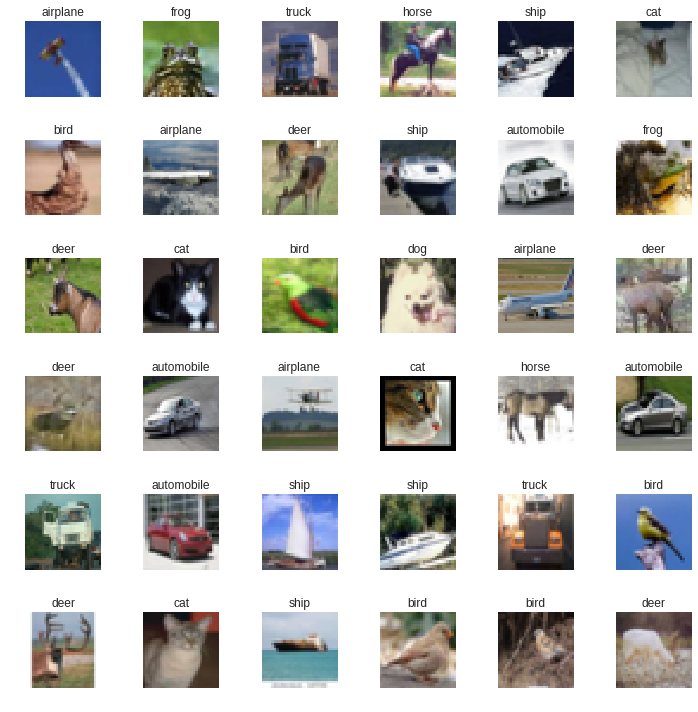

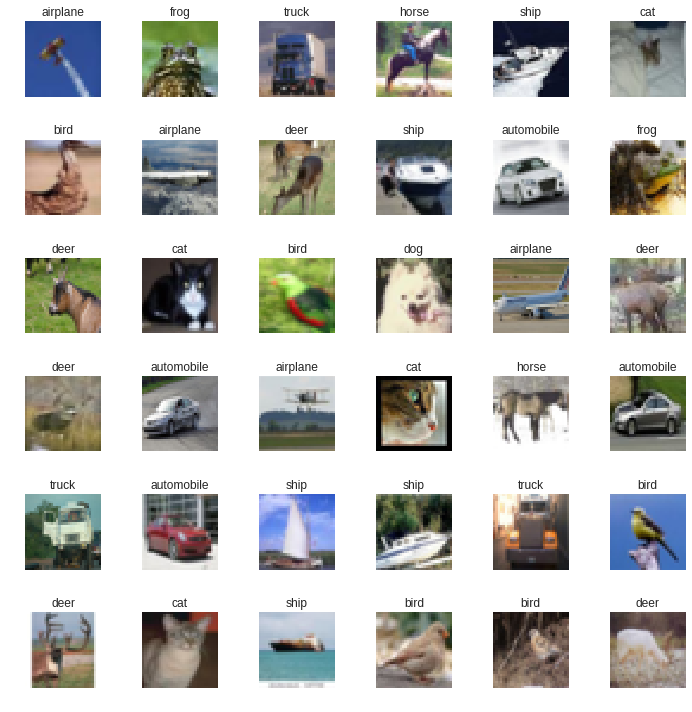

In [17]:
""" Convolutional network applied to CIFAR-10 dataset classification task.
References:
    Learning Multiple Layers of Features from Tiny Images, A. Krizhevsky, 2009.
Links:
    [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)
"""
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

# Data loading and preprocessing
from tflearn.datasets import cifar10
(X, Y), (X_test, Y_test) = cifar10.load_data()
X, Y = shuffle(X, Y)
Y = to_categorical(Y, 10)
Y_test = to_categorical(Y_test, 10)


inds = [np.random.choice(range(len(X))) for i in range(36)]
cifar_grid(X ,Y  ,inds, 6)


In [0]:
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

# Convolutional network building
network = input_data(shape=[None, 32, 32, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)
network = conv_2d(network, 32, 3, activation='relu')
network = max_pool_2d(network, 2)
network = conv_2d(network, 64, 3, activation='relu')
network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network, 2)
network = fully_connected(network, 512, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 10, activation='softmax')
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

# Train using classifier
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit(X, Y, n_epoch=50, shuffle=True, validation_set=(X_test, Y_test),
          show_metric=True, batch_size=96, run_id='cifar10_cnn')

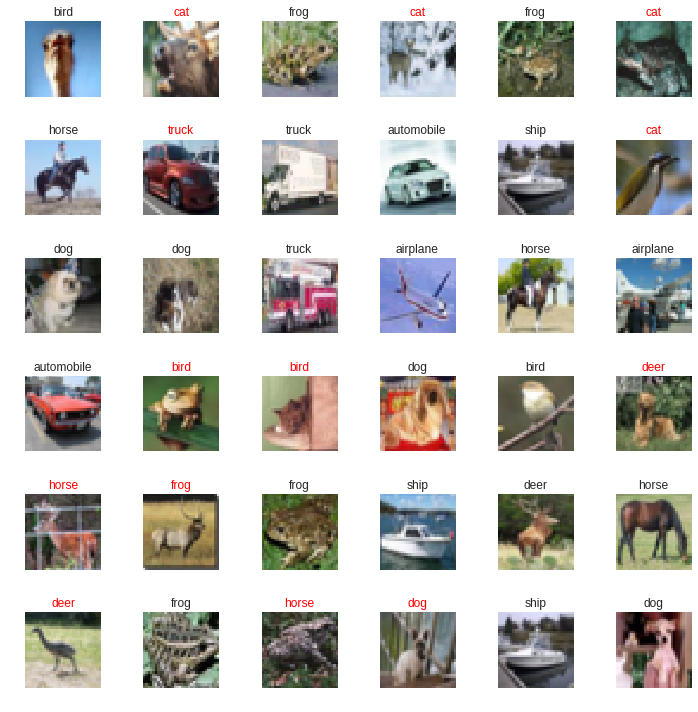

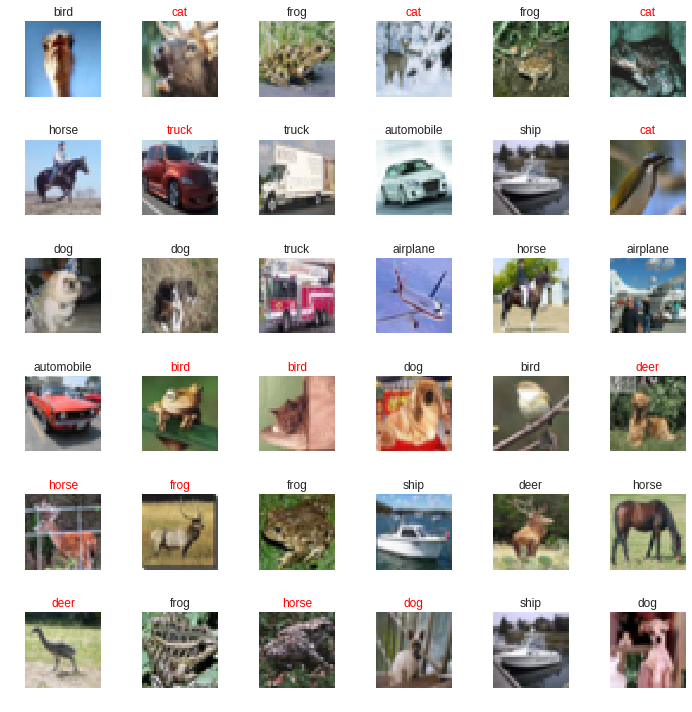

In [18]:

X_test_copy = np.copy(X_test) # copy because predict() modifies input (bug?)
Y_pred = model.predict(X_test_copy)
inds = [np.random.choice(range(len(X_test))) for i in range(36)]
cifar_grid(X_test ,Y_test ,inds,6, Y_pred)